In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.layers import Input, RNN, GRU, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers




In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [2]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    
    return image, results

In [3]:
def draw_styled_landmarks(image, results):
    # Draw left hand Connection
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color = (121, 22, 76), thickness = 2, circle_radius = 4),
                                mp_drawing.DrawingSpec(color = (121, 44, 250), thickness =2, circle_radius =2)
                                ) 
    
    # Draw right hand Connection   
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color = (245, 117, 66), thickness = 1, circle_radius = 4),
                                mp_drawing.DrawingSpec(color = (245, 66, 230), thickness =1, circle_radius =2)
                                )   
    
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [5]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detection
        image, results = mediapipe_detection(frame, holistic)

        # Draw Landmarks
        draw_styled_landmarks (image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully 
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


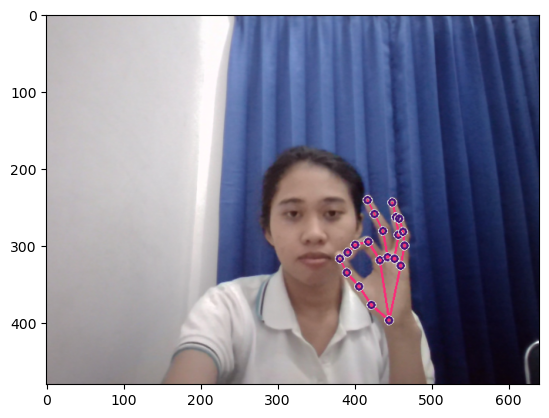

In [6]:
draw_styled_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [7]:
result_test = extract_keypoints(results)

In [8]:
extract_keypoints(results).shape

(126,)

In [6]:
# labelling

DATA_PATH = '../dt-final-100seq'

actions = np.array(['A', 'B', 'C', 'D', 'E', 'F', 
                    'G', 'H', 'I', 'J', 'K', 'L', 
                    'M', 'N', 'O', 'P', 'Q', 'R', 
                    'S', 'T', 'U', 'V', 'W', 'X', 
                    'Y', 'Z', 'Halo', 'Perkenalkan', 'Nama',
                    'Saya', 'Senang', 'Bertemu', 'Kamu'])

sequence_length = 30
label_map = {label:num for num, label in enumerate(actions)}
label_map


{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'Halo': 26,
 'Perkenalkan': 27,
 'Nama': 28,
 'Saya': 29,
 'Senang': 30,
 'Bertemu': 31,
 'Kamu': 32}

In [8]:
ls

 Volume in drive D is Data
 Volume Serial Number is 300E-DC17

 Directory of d:\capstone_project_bangkit\machine-learning\train-code

15/06/2024  12:35    <DIR>          .
15/06/2024  21:20    <DIR>          ..
15/06/2024  10:33           150.123 train-convLSTM-dt-kar.ipynb
15/06/2024  21:22           552.734 train-GRU-dt-kar.ipynb
15/06/2024  10:55           518.417 train-LSTM-dt-kar.ipynb
               3 File(s)      1.221.274 bytes
               2 Dir(s)   3.049.631.744 bytes free


In [9]:
cd ..

d:\capstone_project_bangkit\machine-learning


In [10]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [11]:
np.array(sequences).shape

(3300, 30, 126)

In [12]:
np.array(labels).shape

(3300,)

In [13]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [16]:
print(X_train.shape)
print(X_test.shape)

(2805, 30, 126)
(495, 30, 126)


In [17]:
print(y_train.shape)
print(y_test.shape)

(2805, 33)
(495, 33)


In [18]:
# Define the custom callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if (logs.get('accuracy') > 0.98) and (logs.get('val_accuracy') > 0.95):
            print("\nCategorical accuracy is higher than 0.98 and loss is lower than 0.19, stopping training!")
            self.model.stop_training = True

# Instantiate the custom callback
custom_callback = myCallback()

# Set up the TensorBoard callback
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# Combine both callbacks
callbacks = [custom_callback, tb_callback]

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, RNN, GRU, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

model = Sequential()
model.add(GRU(128, return_sequences=True, activation='relu', input_shape=(30, 126)))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 128)           98304     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [21]:
model.compile(optimizer='Adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

In [26]:
gru_History = model.fit(X_train, 
        y_train, 
        validation_data=(X_test, y_test), 
        epochs=1200)
        # callbacks=[callbacks])

Epoch 1/1200
88/88 [==============================] - 3s 29ms/step - loss: 0.1840 - accuracy: 0.9768 - val_loss: 0.8027 - val_accuracy: 0.8525
Epoch 2/1200
88/88 [==============================] - 3s 30ms/step - loss: 0.4726 - accuracy: 0.8888 - val_loss: 0.2191 - val_accuracy: 0.9697
Epoch 3/1200
88/88 [==============================] - 3s 29ms/step - loss: 0.2220 - accuracy: 0.9647 - val_loss: 0.2805 - val_accuracy: 0.9495
Epoch 4/1200
88/88 [==============================] - 3s 30ms/step - loss: 0.3599 - accuracy: 0.9237 - val_loss: 0.3354 - val_accuracy: 0.9111
Epoch 5/1200
88/88 [==============================] - 3s 30ms/step - loss: 0.1889 - accuracy: 0.9747 - val_loss: 0.1508 - val_accuracy: 0.9818
Epoch 6/1200
88/88 [==============================] - 3s 32ms/step - loss: 0.1990 - accuracy: 0.9668 - val_loss: 0.2333 - val_accuracy: 0.9616
Epoch 7/1200
88/88 [==============================] - 3s 32ms/step - loss: 0.1702 - accuracy: 0.9761 - val_loss: 0.1829 - val_accuracy: 0.9737

In [23]:
model.save('33C_GRU_ac098_ls01_s100_1200epoch.h5')

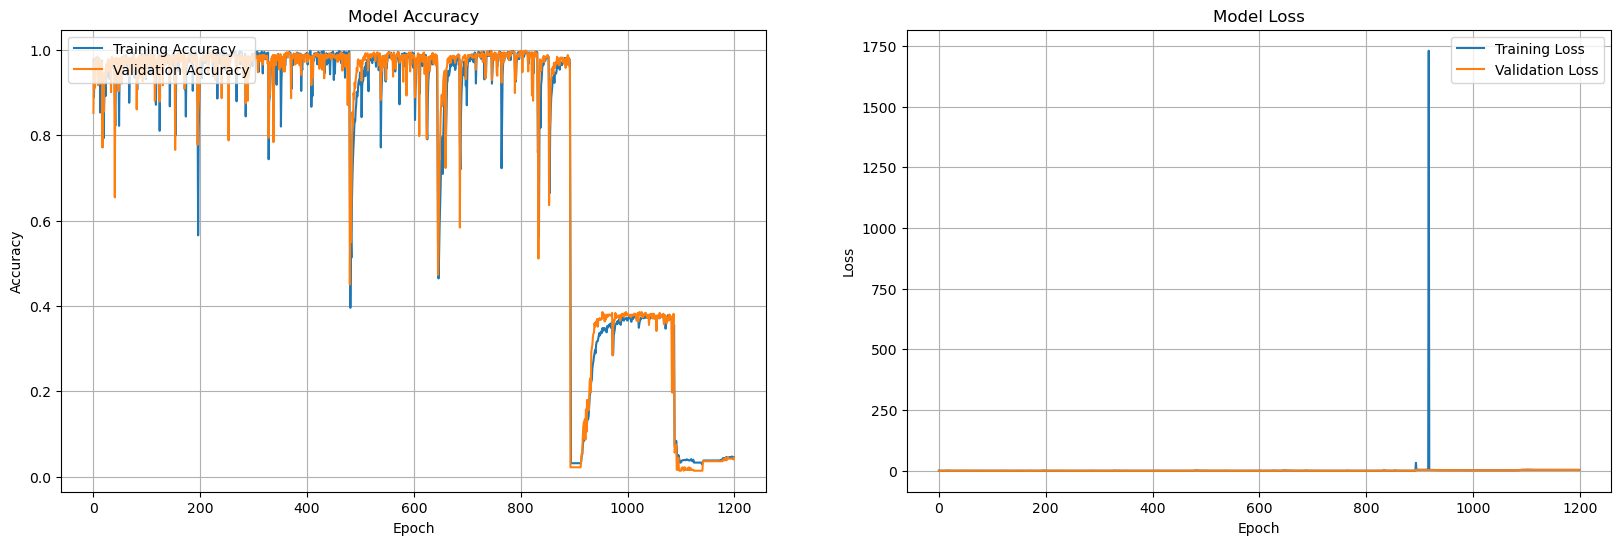

In [27]:
# Assuming convlstm_model_training_history is the variable holding the history after training
history = gru_History.history

# Extract accuracy, validation accuracy, loss, and validation loss
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot accuracy
ax1.plot(accuracy, label='Training Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot loss
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.show()


In [ ]:
# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels from one-hot encoding to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Visualize sample predictions
num_samples = 5
sample_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i+1)
    # Assuming the first frame from the sequence for visualization
    frame = X_test[idx][:, :, 0, 0].reshape((30, 126))  # Reshape for visualization
    
    # Display the first frame of the sequence
    plt.imshow(frame, cmap='gray')
    plt.title(f"True: {actions[y_true_classes[idx]]}\nPred: {actions[y_pred_classes[idx]]}")
    plt.axis('off')

plt.show()